# Diabetes prediction: decision threshold tuning

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, TunedThresholdClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator

import configuration as config
import functions as funcs

## 1. Data preparation

### 1.1. Load data from disk

In [2]:
with open(config.DATA_FILE, 'rb') as input_file:
    dataset=pickle.load(input_file)

training_df=dataset['training']
testing_df=dataset['testing']

### 1.2. Inspect

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
10,0.346287,-0.301950,1.669300,0.205563,0.117037,0.783872,-1.090868,0.032714,0
529,-1.584069,-0.265127,-0.600537,-0.920110,0.183907,-1.235844,0.907265,0.143181,0
131,1.340850,0.122066,-1.356016,0.349894,-0.094144,0.200501,1.653842,0.342824,1
187,-0.812301,0.320701,2.174286,1.183462,-1.281213,0.010094,1.848371,0.342824,1
409,-0.812301,1.571838,-0.348570,1.855405,2.467712,1.364800,1.004892,-0.213442,1


## 2. Model comparisons

### 2.1. LogisticRegression vs RandomForest vs GradientBoostingClassifier

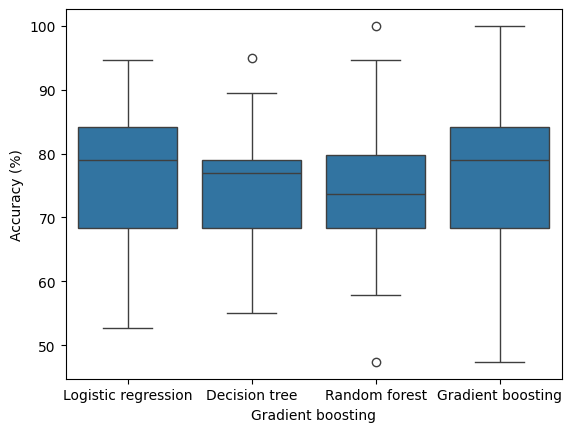

In [4]:
models={}

models['Logistic regression']=LogisticRegression().fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

with open(config.DECISION_TREE_MODEL, 'rb') as input_file:
    models['Decision tree']=pickle.load(input_file)

with open(config.RANDOM_FOREST_MODEL, 'rb') as input_file:
    models['Random forest']=pickle.load(input_file)

with open(config.GRADIENT_BOOSTING_MODEL, 'rb') as input_file:
    models['Gradient boosting']=pickle.load(input_file)

cross_val_scores={
    'Model': [],
    'Score': []
}

for model_name, model in models.items():

    scores=cross_val_score(
        model,
        training_df.drop('Outcome', axis=1),
        training_df['Outcome'],
        cv=30,
        n_jobs=-1
    )

    cross_val_scores['Model'].extend([model_name]*len(scores))
    cross_val_scores['Score'].extend(np.array(scores)*100)

sns.boxplot(pd.DataFrame.from_dict(cross_val_scores), x='Model', y='Score')
plt.xlabel(model_name)
plt.ylabel('Accuracy (%)')
plt.show()

### 5.2. Test set performance

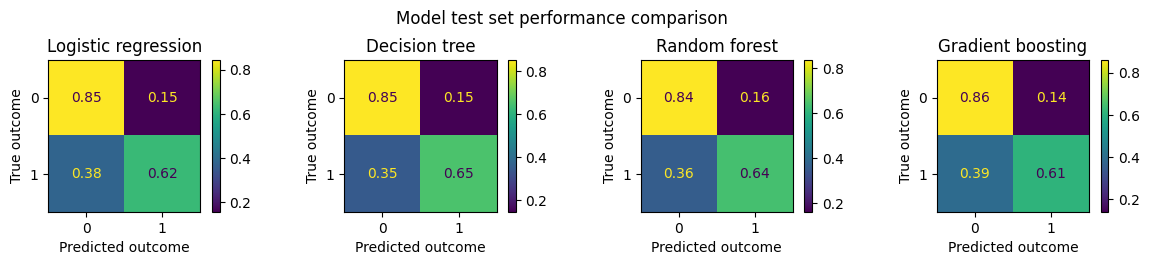

In [5]:
fig, axs = plt.subplots(1,4, figsize=(12,2.5))
axs=axs.flatten()

fig.suptitle(f'Model test set performance comparison')

for i, (model_name, model) in enumerate(models.items()):

    testing_predictions=model.predict(testing_df.drop('Outcome', axis=1))
    accuracy=accuracy_score(testing_predictions, testing_df['Outcome'])*100

    # Plot the confusion matrix
    cm=confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    _=cm_disp.plot(ax=axs[i])

    axs[i].set_title(model_name)
    axs[i].set_xlabel('Predicted outcome')
    axs[i].set_ylabel('True outcome')

fig.tight_layout()

## 6. Call threshold

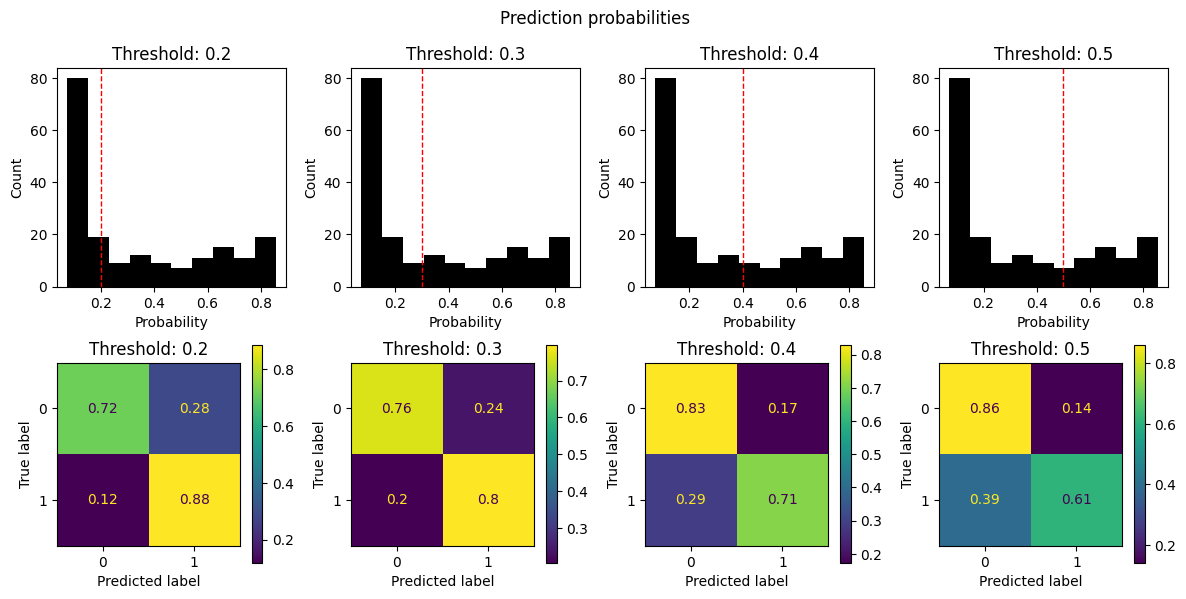

In [6]:
call_thresholds=[0.2, 0.3, 0.4, 0.5]
class_probabilities=models['Gradient boosting'].predict_proba(testing_df.drop('Outcome', axis=1))

fig, axs = plt.subplots(2,4, figsize=(12,6))

fig.suptitle(f'Prediction probabilities')

for i, threshold in enumerate(call_thresholds):

    # Plot the histogram
    axs[0,i].hist(class_probabilities[:,1], color='black')
    axs[0,i].axvline(threshold, color='red', linestyle='dashed', linewidth=1)
    axs[0,i].set_title(f'Threshold: {threshold}')
    axs[0,i].set_xlabel('Probability')
    axs[0,i].set_ylabel('Count')

    # Plot the confusion matrix
    calls=[1 if p > threshold else 0 for p in class_probabilities[:,1]]
    accuracy=accuracy_score(calls, testing_df['Outcome'])*100

    cm=confusion_matrix(testing_df['Outcome'], calls, normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)

    axs[1,i].set_title(f'Threshold: {threshold}')
    _=cm_disp.plot(ax=axs[1,i])

fig.tight_layout()

## 3. Threshold tuning

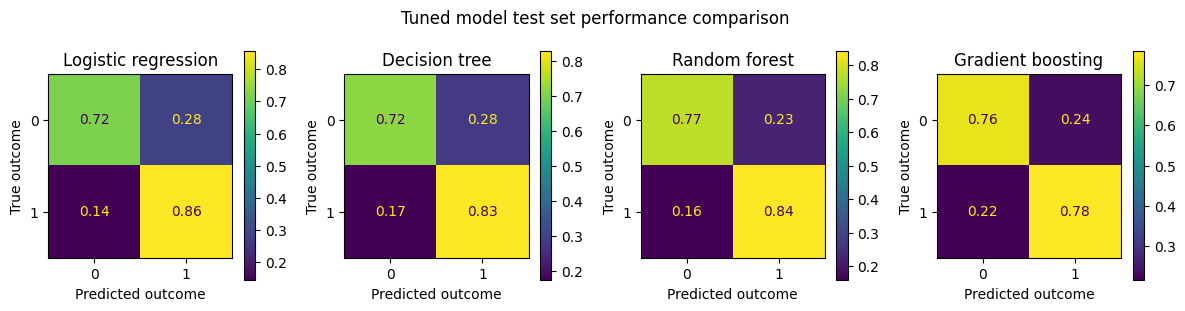

In [7]:
fig, axs = plt.subplots(1,4, figsize=(12,3))
axs=axs.flatten()

fig.suptitle(f'Tuned model test set performance comparison')

for i, (model_name, model) in enumerate(models.items()):

    tuned_model=TunedThresholdClassifierCV(
        model,
        scoring='f1'
    )

    tuned_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
    models[model_name]=tuned_model

    testing_predictions=tuned_model.predict(testing_df.drop('Outcome', axis=1))
    accuracy=accuracy_score(testing_predictions, testing_df['Outcome'])*100

    # Plot the confusion matrix
    cm=confusion_matrix(testing_df['Outcome'], testing_predictions, normalize='true')
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    _=cm_disp.plot(ax=axs[i])

    axs[i].set_title(model_name)
    axs[i].set_xlabel('Predicted outcome')
    axs[i].set_ylabel('True outcome')

fig.tight_layout()

In [8]:
print(f'Optimized threshold: {tuned_model.best_threshold_}')

Optimized threshold: 0.3177001836915317
